<p align = 'center'>
    <img width = "300" src = 'Images/logo.png'>
</p>


# Understanding the camera calibration process

Use the *Rigid Body Tracking* package and the CoppeliaSim API to understand and analyze the image formation and the camera calibration problem. 

**Objective:** Represent the camera projection and use the virtual environment to compare the image points with the CoppeliaSim's visual sensor image.

<p align = 'center'>
    <img src = 'Images/camera-projection.png'>
</p>

---

## Mathematical foundation of the perspective camera

<p align = 'center'>
    <img src = 'Images/image-plane.jpeg'>
</p>


The point $p$ in the image plane is described by:
$$ x = f\frac{X}{Z}$$
$$ y = f\frac{Y}{Z}$$


Writing the point $p$ in homogenous coordinates: 
$$ \tilde{x} = fX $$
$$ \tilde{y} = fY $$
$$ \tilde{z} = Z $$

In matrix form: 

$$ \tilde{p} = \begin{pmatrix} f & 0 & 0\\ 0 &f  &0 \\ 0 & 0 &1 \end{pmatrix}
\cdot \begin{pmatrix} X\\ Y\\ Z \end{pmatrix} $$

Where the nonhomogeneous image-plane coordinates are: 

$$ x = \frac{\tilde{x}}{\tilde{z}} $$
$$ y = \frac{\tilde{y}}{\tilde{z}} $$


<p align = 'center'>
    <img src = 'Images/camera-pose.jpeg'>
</p>

The world point P need to be written in respect to the camera coordinate frame. The coordinate vector of the world point with respect to the camera frame can be describe as: 

$${^CP}= {^OE_C} \cdot {^OP} $$ 

Where ${^OE_C}$ is the transformation matrix of the world coordinate frame to the camera coordinate frame. This transformation is describe as a rotation and a translation combined. 


Now, the perspective projection of a camera is: 

$$ \begin{pmatrix}
\tilde{x}\\ 
\tilde{y}\\ 
\tilde{z}
\end{pmatrix}= \begin{pmatrix}
f & 0 & 0\\ 
0 &f  &0 \\ 
0 & 0 &1 
\end{pmatrix}\cdot 
\begin{pmatrix}
{^CR_O} & {^Ct_O}\\ 
0 & 1
\end{pmatrix}
\begin{pmatrix}
X\\ 
Y\\ 
Z\\
1
\end{pmatrix}$$ 


$$ \tilde{p} = M_{int}\cdot M{ext}\cdot \tilde{P}$$ 

---

<p align = 'center'>
    <img src = 'Images/visual-sensor-properties.png'>
</p>


In CoppeliaSim, the camera is represented by the visual sensor. The focal length of the visual sensor can be determined based on the angle of view.

$$
        f = \frac{d}{2\tan (\frac{\theta}{2}) }
$$

Where $d$ is the sensor size in mm and $\theta$ is the angle of view. To find the focal length in pixels, consider the sensor size in pixels

\begin{align*}
        f_x &= \frac{R_x}{2\tan (\frac{\theta}{2})}\\
        f_y &= \frac{R_y}{2\tan (\frac{\theta}{2})}
\end{align*}

Considering the principal point of an image is in your center
\begin{align*}
        O_x &= \frac{R_x}{2} \\
        O_y &= \frac{R_y}{2}
\end{align*}

The intrinsic matrix is: 
\begin{equation*}
        K = \begin{pmatrix}
                f_x & 0 & O_x\\ 
                0 & f_y &O_y \\ 
                0 & 0 & 1   
            \end{pmatrix}
\end{equation*}

---

Extract the rotation and translation relating to the visual sensor frame using the CoppeliaSim Remote API


<p align = 'center'>
    <img src = 'Images/extrinsic-step.png'>
</p>

---

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from cv2 import projectPoints, Rodrigues
from modules.viewer import Viewer
from modules.feed import Feed
from modules.frame import Frame
from modules.rigid import *
from modules.camera import *

from coppeliasim_zmqremoteapi_client import RemoteAPIClient


### Generate random world points and see their projections in image plane

In [14]:
# Generate random point for scene 
number_of_points = 15
points_in_scene = generate_random_points(number_of_points)

# Reshape for better printing 
print("The random points are: \n", points_in_scene.T.reshape(number_of_points,3))

The random points are: 
 [[0.00697535 0.53734694 0.06399189]
 [0.52544466 0.52161818 0.89094868]
 [0.41321714 0.54337737 0.34220374]
 [0.29285748 0.78414804 0.74364952]
 [0.67791275 0.8877924  0.09812197]
 [0.30185394 0.60002253 0.14529262]
 [0.37306878 0.74293567 0.57966438]
 [0.29440823 0.16776157 0.46994537]
 [0.6634013  0.41206394 0.04990312]
 [0.11497147 0.94820056 0.6051913 ]
 [0.16611165 0.33849381 0.26277516]
 [0.10708771 0.1018851  0.18205002]
 [0.20225069 0.20987723 0.95035758]
 [0.35169369 0.93926011 0.97601368]
 [0.39302153 0.66468565 0.98300009]]


### Plot the setup

In [15]:
def build_intrinsic_matrix(fov_degrees, resolution):
    fov_radians = np.radians(fov_degrees)

    f_x = resolution[0]/(2*np.tan(fov_radians/2))
    f_y = resolution[1]/(2*np.tan(fov_radians/2))

    o_x = resolution[0]/2
    o_y = resolution[1]/2

    camera_matrix = np.array([[-f_x,   0, o_x, 0],
                              [  0, -f_y, o_y, 0],
                              [  0,    0,   1, 0]])

    return camera_matrix

def build_extrinsic_matrix(vision_sensor_handle):
    camera_pose = np.vstack((np.array(sim.getObjectMatrix(vision_sensor_handle)).reshape((3,4)), np.array([0, 0, 0, 1])))

    return camera_pose

def build_projection_matrix(intrinsic_matrix, extrinsic_matrix):
    projection_matrix = intrinsic_matrix @ inverse_homo(extrinsic_matrix) 

    return projection_matrix

def perspective_projection(points, projection_matrix):
    projected_point = projection_matrix @ points  # Project points to plane
    projected_point /= projected_point[-1]        # Normalize homogeneous coordinates
    projected_point = projected_point[:-1, :]     # Discard the last row
    projected_point = projected_point.astype(int) # Cast as interger
    
    return projected_point

# Declare intrinsic parameters
fov_degrees = 60.0
resolution = (480, 480)

# Generate intrinsic parameters matrix
intrinsic_matrix = build_intrinsic_matrix(fov_degrees, resolution) 

client = RemoteAPIClient()
sim = client.getObject('sim')

# Get the vision sensor handle
vision_sensor_handle = sim.getObject('/Vision_sensor') 

# Generate extrinsic parameters matrix
extrinsic_matrix = build_extrinsic_matrix(vision_sensor_handle)

# Generate perspective projection matrix
projection_matrix = build_projection_matrix(intrinsic_matrix, extrinsic_matrix)

# 3D point to be projected in homogeneous coordinates
points_to_project = to_homo(cube()) # Vertices of a cube

# Change cube position
points_to_project[0] -= 0.25
points_to_project[1] -= 0.25
points_to_project[2] += 1

# Create the Scene Viewer
scene = Viewer('Camera Pose Scene', size = 5)

# Add elements to the scene
scene.add_frame(Frame(), 'World Frame', axis_size=0.2)
scene.add_frame(Frame(*split_homo(extrinsic_matrix)), 'Camera Frame', axis_size=0.2) 
scene.add_points(points_to_project, 'World Points', 'black')

# Plot scene
scene.figure.show(renderer='notebook_connected')

# Project the 3D point with the new pose
projected_points = perspective_projection(points_to_project, projection_matrix)

# Create the image viewer
image = Feed('Camera Image', resolution, graphical=True)

# Adding the projected points to the scene
image.add_points(projected_points, 'Image Point', 'black')

# Plot image
image.figure.show(renderer='notebook_connected')

# Print Results (Compare with simulation!)
print('Projected Points in Pixel Coordinates:')
print(projected_points)

Projected Points in Pixel Coordinates:
[[252 252 215 215 146 144  78  73]
 [337 221 387 228 328 220 370 226]]


# Coppelia Enviroment

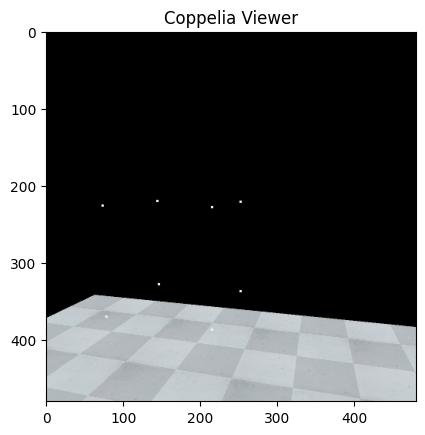

Detected Points in Pixel Coordinates:
[[215  78 252 146 215  73 252 144]
 [387 370 337 328 228 226 221 220]]


In [16]:
# When simulation is not running, ZMQ message handling could be a bit
# slow, since the idle loop runs at 8 Hz by default. So let's make
# sure that the idle loop runs at full speed for this program:
defaultIdleFps = sim.getInt32Param(sim.intparam_idle_fps)   
sim.setInt32Param(sim.intparam_idle_fps, 0)

# Run a simulation in stepping mode:
sim.startSimulation()

point_cloud_handle = sim.createPointCloud(1, 1, 8, 3)
markers_color = list([255,255,255]) 

# Insert points into point cloud
points = np.concatenate(points_to_project[:-1, :].T)

points = points.tolist()

point_count = sim.insertPointsIntoPointCloud(point_cloud_handle, 0, points, markers_color)

coppelia_centroids = None
img = []

# Other blob detection method
while (t := sim.getSimulationTime()) < 1:
    img, resX, resY = sim.getVisionSensorCharImage(vision_sensor_handle)
    img = np.frombuffer(img, dtype=np.uint8).reshape(resY, resX, 3)

    # In CoppeliaSim images are left to right (x-axis), and bottom to top (y-axis)
    # (consistent with the axes of vision sensors, pointing Z outwards, Y up)
    # and color format is RGB triplets, whereas OpenCV uses BGR:
    img = cv2.flip(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0)
    
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Convert the grayscale image to binary image
    _,thresh = cv2.threshold(gray_image,230,255,0)

    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        # Calculate moments of each contour
        M = cv2.moments(c)
        
        # Calculate x,y coordinate of center
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            print('Point not detected!')
            break
        
        centroids = np.array([cX, cY]).reshape(-1,1)

        if coppelia_centroids is None:
            coppelia_centroids = centroids
        else:
            coppelia_centroids = np.hstack((coppelia_centroids, centroids))

    break # Just execute the first loop

# Restore the original idle loop frequency:
sim.setInt32Param(sim.intparam_idle_fps, defaultIdleFps)

sim.stopSimulation()

# Display the image
plt.imshow(img)
plt.title('Coppelia Viewer')
plt.show()

# Print Results (Compare with math model!)
print('Detected Points in Pixel Coordinates:')
print(coppelia_centroids)


## Calibrate your camera with DLT

In [17]:
# Find the camera matrix [ndarray (3,4)] by computing DLT
dlt_camera_matrix = calibrate_camera(points_to_project[:-1,:].T, projected_points.T)

estimated_image_points = perspective_projection(points_to_project,dlt_camera_matrix)

print("The ground truth camera matrix: \n", projection_matrix)

print("Estimated image points \n", estimated_image_points)
print("Ground truth projected points: \n", projected_points)

# Create the image viewer
image = Feed('Camera Image', resolution, graphical=True)

# Adding the projected points to the scene
image.add_points(estimated_image_points, 'Image Point', 'black')

# Plot image
image.figure.show(renderer='notebook_connected')


DLT camera matrix: 
 [[-2.71079760e-01 -2.70802495e-01 -1.61390625e-02  2.41667334e-01]
 [ 4.56325427e-02 -1.56420227e-01 -3.48390205e-01  8.04108413e-01]
 [ 2.19230934e-04 -7.73276947e-04 -6.84380772e-05  1.36385405e-03]]
The ground truth camera matrix: 
 [[-3.39647627e+02 -3.38529102e+02 -2.09173783e+01  3.03041110e+02]
 [ 5.25031944e+01 -1.95944589e+02 -4.35027738e+02  1.00341542e+03]
 [ 2.57834160e-01 -9.62250187e-01 -8.71557427e-02  1.70012527e+00]]
Estimated image points 
 [[251 252 215 214 146 144  77  73]
 [337 220 386 228 327 219 369 226]]
Ground truth projected points: 
 [[252 252 215 215 146 144  78  73]
 [337 221 387 228 328 220 370 226]]


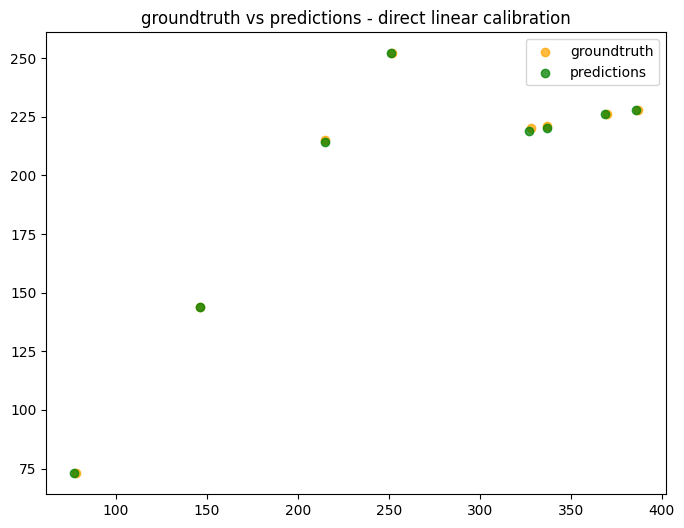

In [18]:
'''# Find the camera matrix [ndarray (3,4)] by computing DLT
dlt_camera_matrix = calibrate_camera(cube().T, image_points.T)

# Find K,R and t by RQ factorization
estimated_intrinsic, estimated_r_matrix, estimated_t_vector = extract_camera_parameters(dlt_camera_matrix)

# Create the estimated extrinsic matrix 
estimated_extrinsic = join_homo(estimated_r_matrix,estimated_t_vector.reshape(-1,1))
estimated_extrinsic = estimated_extrinsic[:-1,:]'''

# Project the world points using the estimated parameters

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

for i in range(cube().shape[1]):
    if i == 0:
        o_label = "groundtruth"
        g_label = "predictions"
    else:
        o_label = ""
        g_label = ""
        
    ax.scatter(*projected_points.reshape(-1, 2)[i], color="orange", alpha=0.75, label=o_label)
    ax.scatter(*estimated_image_points.reshape(-1, 2)[i], color="green", alpha=0.75, label=g_label)
    
ax.set_title("groundtruth vs predictions - direct linear calibration")
ax.legend()
